In [1]:
from client.model import compile_model, save_parameters, load_parameters
from client.startup import MyClient, prepare_data
from client.data import get_data
from server_functions import ServerFunctions
from scaleout.client.edge_client import EdgeClient
import torch
import matplotlib.pyplot as plt


#get_data('C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/server-functions/max_data')
model = compile_model()
print(model)

N_clients = 2
edge = EdgeClient()
clients = dict()
clients = [MyClient(edge) for _ in range(N_clients)]
#prepare_data()




2026-02-12 14:18:36 [DEBUG] Token cache initialized at: C:\Users\maxha\.scaleout\tokens\api-client.json
Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [17]:
from pathlib import Path
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from collections import defaultdict


def split_mnist_by_class(
    root: str = "max_data",
    train: bool = True,
):
    """
    Splits MNIST into separate files per class.

    Saves files to:
        max_data/mnist/class_{digit}.pt
    """
    root = Path(root)
    out_dir = root / "mnist_part"
    out_dir.mkdir(parents=True, exist_ok=True)

    dataset = MNIST(
        root=root,
        train=train,
        download=False,
        transform=transforms.ToTensor(),
    )

    buckets = defaultdict(list)

    for img, label in dataset:
        buckets[label].append(img)

    for label, images in buckets.items():
        images = torch.stack(images)
        labels = torch.full((len(images),), label)

        torch.save(
            {"x_train": images, "y_train": labels},
            out_dir / f"class_{label}.pt",
        )

    print(f"Saved MNIST split by class to: {out_dir}")



import random
def create_non_iid_mnist_clients(
    root: str = "max_data",
    n_clients: int = 5,
    classes_per_client: int = 2,
    samples_per_class: int | None = None,
    train: bool = True,
    seed: int = 42,
):
    """
    Creates non-IID MNIST partitions across clients.

    Each client receives `classes_per_client` digit classes.
    Optionally limits samples per class.

    Output:
        max_data/mnist_clients/client_{id}.pt
    """
    assert n_clients * classes_per_client <= 10, \
        "Too many clients/classes requested for MNIST."

    random.seed(seed)

    root = Path(root)
    out_dir = root / "mnist_clients"
    out_dir.mkdir(parents=True, exist_ok=True)

    dataset = MNIST(
        root=root,
        train=train,
        download=True,
        transform=transforms.ToTensor(),
    )

    # Collect indices by class
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)

    # Shuffle class indices
    for indices in class_to_indices.values():
        random.shuffle(indices)

    # Assign classes to clients
    all_classes = list(range(10))
    random.shuffle(all_classes)

    client_classes = {
        client_id: all_classes[
            client_id * classes_per_client :
            (client_id + 1) * classes_per_client
        ]
        for client_id in range(n_clients)
    }

    # Build client datasets
    for client_id, classes in client_classes.items():
        images, labels = [], []

        for cls in classes:
            indices = class_to_indices[cls]
            if samples_per_class:
                indices = indices[:samples_per_class]

            for idx in indices:
                img, label = dataset[idx]
                images.append(img)
                labels.append(label)

        images = torch.stack(images)
        labels = torch.tensor(labels)

        torch.save(
            {
                "x_train": images,
                "y_train": labels,
                "classes": classes,
            },
            out_dir / f"client_{client_id}.pt",
        )

    print(f"Saved non-IID MNIST clients to: {out_dir}")

create_non_iid_mnist_clients(
    root="max_data",
    n_clients=2,
    classes_per_client=3,
    #samples_per_class=,  # optional
)
#split_mnist_by_class()


Saved non-IID MNIST clients to: max_data\mnist_clients


2  non-iid splits


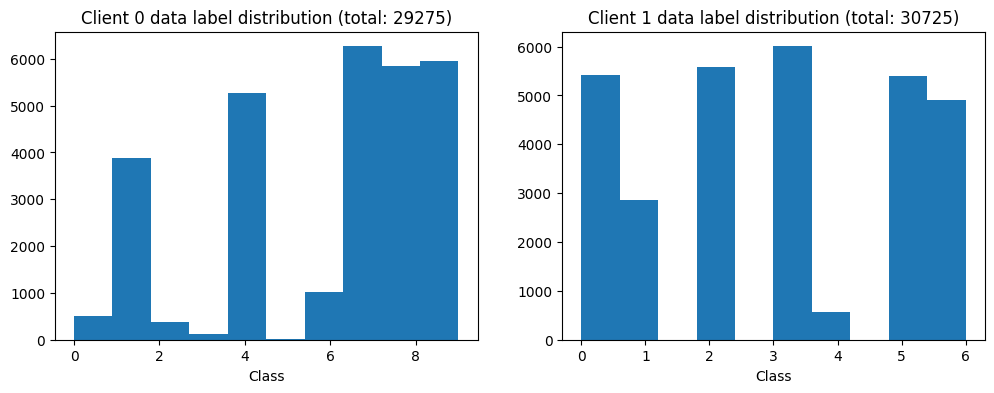

In [ ]:
import pickle
import torchvision
from torchvision import transforms
def niid_loader(data_path=None, is_train=True, idx_dict_path=None):

    with open(idx_dict_path, 'rb') as f:
        idx_dict = pickle.load(f)

    
    if data_path == None:
        print('No data path given!')
        return
        
    elif idx_dict == None:
        print('No dictionary for mapping non-iid datadata to clients!')
        return
    
    #data = torch.load(data_path, weights_only=True)
    #Imagenette
    # data = torchvision.datasets.Imagenette(
    #     root=data_path, 
    #     train=is_train,
    #     download=False,
    #     transform=transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Normalize(
    #             mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225],
    #         ),
    #     ])
    # )
    
    # X = []
    # y = []

    # for img, label in data:
    #     X.append(img)
    #     y.append(label)

    # X = torch.stack(X)   # [N, 3, 224, 224]
    # y = torch.tensor(y)


    data = torchvision.datasets.MNIST(
        root=data_path, 
        train=is_train,
        download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
        ])
    )

    X = data.data
    y = data.targets
    # Normalize
    X = X / 255.0

    out_x = []
    out_y = []
    for key, subset in idx_dict.items():
        out_x.append(X[subset])
        out_y.append(y[subset])
    print(len(out_x), ' non-iid splits')

    return out_x, out_y

imgs, labels = niid_loader(
    data_path='C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/server-functions/max_data/', 
    is_train=True, 
    idx_dict_path='C:/Users/maxha/OneDrive - RISE/Documents/NIID-Bench/max_partitions/net_dataidx_map_labeldir_beta05.pkl',
    )

#Client data distribution
fig, axs = plt.subplots(1,N_clients, figsize=(12,4))
for i, client_labels in enumerate(labels):
    axs[i].hist(client_labels)
    axs[i].set_title(f'Client {i} data label distribution (total: {len(client_labels)})')
    axs[i].set_xlabel('Class')
plt.show()

In [5]:
from copy import deepcopy
from scaleoututil.serverfunctions.serverfunctionsbase import RoundType
from scaleoututil.utils.model import ScaleoutModel
from collections import defaultdict


#initialize global params
global_params = save_parameters(model)


client_ids = [i for i in range(N_clients)]
server_functions = ServerFunctions()
metrics_list = defaultdict(lambda: defaultdict(list))


#for .. (this is one FL round)
for round in range(8):
    selected = server_functions.client_selection(client_ids, RoundType.TRAINING) 
    settings = server_functions.client_settings(global_params) #Transform to list

    params_list = dict()
    losses = []
    for id in client_ids:
        #Olika datapartitioner på olika clients
        params, metadata, metrics = clients[id].train(
            scaleout_model=global_params, 
            settings=settings,
            #data_path=f'max_data/mnist_clients/client_{id}.pt'
            x_train=imgs[id],
            y_train=labels[id],
            )
        params_list[id] =(params.get_model_params(), metadata)

        metrics_list[id]['training_loss'].append(metrics['training_loss'])
        metrics_list[id]['training_accuracy'].append(metrics['training_accuracy'])

    #Aggregate
    new_params = server_functions.aggregate(global_params.get_model_params(), params_list)
    global_params = global_params.from_model_params(new_params)



Epoch 0/0 | Batch 0/914 | Loss: 2.2319
Epoch 0/0 | Batch 100/914 | Loss: 2.1179
Epoch 0/0 | Batch 200/914 | Loss: 1.8671
Epoch 0/0 | Batch 300/914 | Loss: 1.7155
Epoch 0/0 | Batch 400/914 | Loss: 1.2955
Epoch 0/0 | Batch 500/914 | Loss: 1.2415
Epoch 0/0 | Batch 600/914 | Loss: 0.9843
Epoch 0/0 | Batch 700/914 | Loss: 1.1430
Epoch 0/0 | Batch 800/914 | Loss: 0.9596
Epoch 0/0 | Batch 900/914 | Loss: 0.6765
2026-02-12 14:19:29 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 1.4256 | Acc: 0.5134
Epoch 0/0 | Batch 0/960 | Loss: 2.3274
Epoch 0/0 | Batch 100/960 | Loss: 2.0879
Epoch 0/0 | Batch 200/960 | Loss: 1.8541
Epoch 0/0 | Batch 300/960 | Loss: 1.8076
Epoch 0/0 | Batch 400/960 | Loss: 1.5142
Epoch 0/0 | Batch 500/960 | Loss: 1.1270
Epoch 0/0 | Batch 600/960 | Loss: 0.9848
Epoch 0/0 | Batch 700/960 | Loss: 0.9525
Epoch 0/0 | Batch 800/960 | Loss: 0.8249
Epoch 0/0 | Batch 900/960 | Loss: 0.7275
2026-02-12 14:19:30 [ERROR] Missing context for logging metric.
Epoch 0 fi

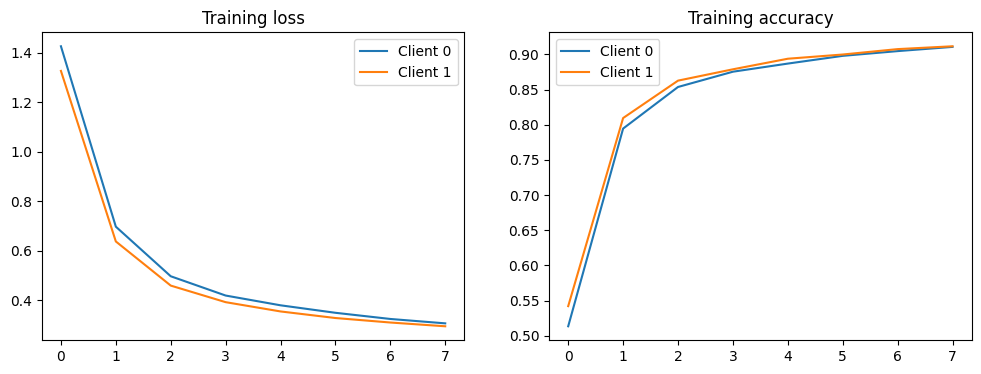

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for id in client_ids:
    ax1.plot(metrics_list[id]['training_loss'], label=f'Client {id}')
    ax2.plot(metrics_list[id]['training_accuracy'], label=f'Client {id}')


ax1.legend()
ax1.set_title('Training loss')

ax2.legend()
ax2.set_title('Training accuracy')
plt.show()
